<a href="https://colab.research.google.com/github/KrishnanandSingh/EVA/blob/master/Project-11/Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn import model_selection

import keras
from keras import backend as K
from keras import regularizers, initializers, layers, models
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model

import tensorflow as tf

np.random.seed(2017) 
% matplotlib inline

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [3]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


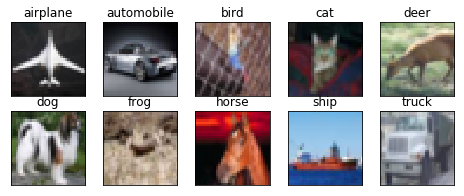

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Mounting google drive to store models

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!mkdir /content/drive/'My Drive'/assignment_11/
os.chdir('/content/drive/My Drive/assignment_11/')

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/assignment_11/’: File exists


### Helper methods

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Define Random eraser for cutout

ref: https://github.com/yu4u/cutout-random-erasing

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


Define LR finder

---
Ref: http://puzzlemusa.com/2018/05/14/learning-rate-finder-using-keras/

In [0]:
import math
from keras.callbacks import LambdaCallback


class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

Define method to find misclassified images

In [0]:
def find_misclassified_images(X, y_true, y_pred, max_samples=0):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    result = np.absolute(y_true-y_pred)
    misclassified_indices = np.nonzero(result)
    X_misclassified = X[misclassified_indices]
    y_true_misclassified = y_true[misclassified_indices]
    y_pred_misclassified = y_pred[misclassified_indices]
    if max_samples >0 :
      return X_misclassified[:max_samples], y_true_misclassified[:max_samples], y_pred_misclassified[:max_samples]
    else:
      return X_misclassified, y_true_misclassified, y_pred_misclassified

Helper methods for calculating gradcam and displaying

---
Ref: https://github.com/faizanahemad/data-science-utils

In [0]:
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(2017)

import cv2
import random

import matplotlib.gridspec as gridspec

from keras.preprocessing import image
import numpy as np

def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

def gradcam(model, layer, img, class_idx, preprocess_func=None, preprocess_img=min_max_scale,
            show=False):
    x = np.expand_dims(image.img_to_array(img), axis=0)
    img = np.copy(img)
    class_idx = np.argmax(class_idx, axis=0) if type(class_idx) == list or type(class_idx) == np.ndarray else class_idx
    if preprocess_func is not None:
        x = preprocess_func(x)
    if preprocess_img is not None:
        img = preprocess_img(img)
    preds = model.predict(x)
    preds = np.argmax(preds, axis=1)[0]

    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer)
    layer_out_channels = last_conv_layer.output_shape[-1]

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(layer_out_channels):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    heatmap = heatmap / 255
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if heatmap[i][j][1] <= 0.01 and heatmap[i][j][2] <= 0.01:
                heatmap[i][j] = 0

    superimposed_img = 0.6 * img + 0.4 * heatmap
    for i in range(len(heatmap)):
        for j in range(len(heatmap[0])):
            if np.sum(heatmap[i][j]) == 0:
                superimposed_img[i][j] = img[i][j]

    superimposed_img = np.clip(superimposed_img, 0, 1, )
    if show:
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        plt.imshow(heatmap)
        plt.axis("off")
        plt.show()
        plt.imshow(superimposed_img)
        plt.axis("off")
        plt.show()
    return img, heatmap, superimposed_img, preds


def show_examples_with_gradcam(model, layer, images, labels, classes=None, preprocess_func=None, preprocess_img=min_max_scale,
                               image_size_multiplier=3,
                               show_actual=True, show_heatmap=False, show_superimposed=True):
    columns = 5
    rows = int(np.ceil(len(images) / columns))
    num_inner_rows = int(show_actual + show_heatmap + show_superimposed)
    labels = np.argmax(labels, axis=1) if type(labels[0]) == list or type(labels[0]) == np.ndarray else labels
    fig_height = rows * image_size_multiplier * num_inner_rows
    fig_width = columns * image_size_multiplier
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer = gridspec.GridSpec(rows, columns, wspace=0.0, hspace=0.2)
    for i in range(rows * columns):
        if i >= len(images):
            break
        x = images[i]
        y = labels[i]
        img, heatmap, superimposed_img, prediction = gradcam(model, layer, x, y,
                                                             preprocess_func=preprocess_func,
                                                             preprocess_img=preprocess_img,
                                                             show=False)
        inner = gridspec.GridSpecFromSubplotSpec(num_inner_rows, 1,
                                                 subplot_spec=outer[i], wspace=0.0, hspace=0.05)

        imgs = []
        if show_actual:
            imgs.append(img)
        if show_heatmap:
            imgs.append(heatmap)
        if show_superimposed:
            imgs.append(superimposed_img)
        label = classes[y] if classes is not None else ""
        label = label.split(' ', 1)[0]
        prediction = classes[prediction]
        titles = [("Actual:" + label + " Pred:" + prediction).replace(' ', '\n')]
        for j in range(num_inner_rows):
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(imgs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(titles.pop() if len(titles) > 0 else "")
            fig.add_subplot(ax)

    fig.show()

### Prepare data and define model

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [11]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

Defining model

In [12]:
# Define the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())

model.add(Activation('softmax'))

W0729 10:05:03.653454 140276472801152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
W0729 10:05:03.670164 140276472801152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 10:05:03.673054 140276472801152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 10:05:03.704003 140276472801152 deprecation_wrapper.py

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Finding best lr and training for 100 epochs

In [14]:
# Compile the model
model.compile(optimizer=keras.optimizers.SGD(momentum=0.9),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
initial_weights_file = 'initial_weights.h5'
model.save_weights(initial_weights_file)

batch_size = 128

lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/batch_size))
model.fit(train_features, train_labels, callbacks=[lr_finder] )

W0729 10:05:05.201053 140276472801152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 10:05:05.724952 140276472801152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
12032/50000 [======>.......................] - ETA: 20s - loss: 3.8420 - acc: 0.1873

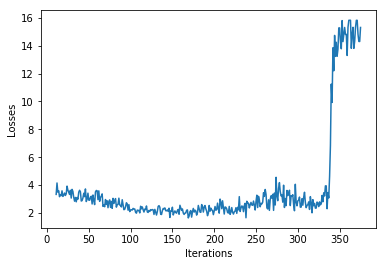

In [15]:
lr_finder.plot_loss()

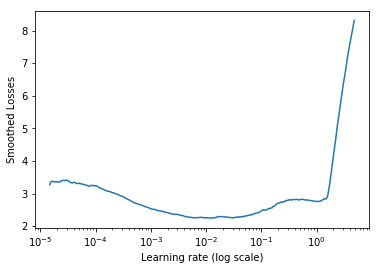

In [16]:
lr_finder.plot_smoothed_loss()

In [17]:
least_smooth_loss = np.amin(lr_finder.smoothed_losses)
lsl_idx = np.where(lr_finder.smoothed_losses == np.amin(least_smooth_loss))[0][0]
best_lr = lr_finder.lrs[lsl_idx]

print('least smooth loss value is: {} at index: {}'.format(least_smooth_loss, lsl_idx))
print('and corresponding LR value is: {}'.format(best_lr))

least smooth loss value is: 2.248883208535043 at index: 199
and corresponding LR value is: 0.01172340337865292


Setting best LR to the model

In [0]:
model.load_weights(initial_weights_file)
K.set_value(model.optimizer.lr, best_lr)

Starting training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=0, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`


Model took 1136.71 seconds to train


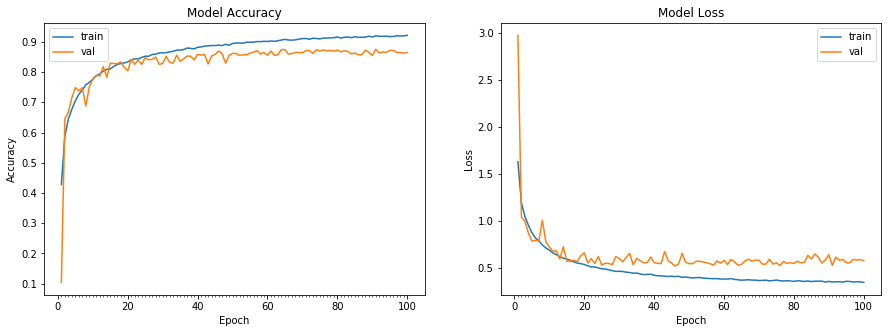

Accuracy on test data is: 86.45


In [19]:
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(p=0.5, 
                                          v_l=0, v_h=1, pixel_level=False))

# p : the probability that random erasing is performed
# v_l, v_h : minimum / maximum value for erased area
# pixel_level : pixel-level randomization for erased area

filepath="assignment11_checkpoint.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Train the model
start = time.time()
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=0,
                                 callbacks = callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Loading best model

In [20]:
model = load_model(filepath)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 87.51


### Running GradCAM on 25 misclassified images

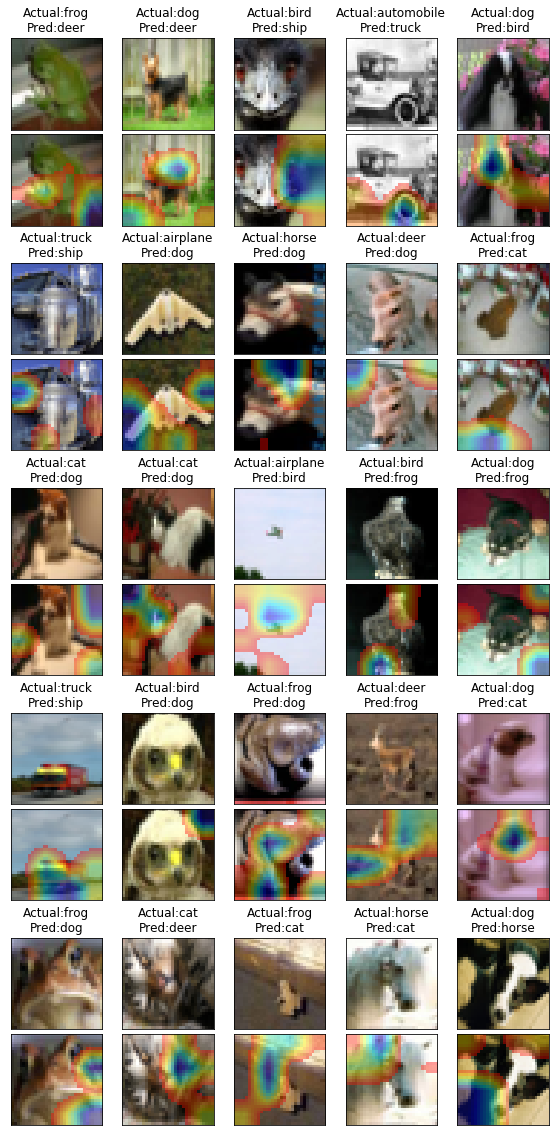

In [23]:
preds = model.predict(test_features)

misclassified_samples = 25
images, y_true, y_pred  = find_misclassified_images(test_features, test_labels, preds, misclassified_samples)
show_examples_with_gradcam(model, 'max_pooling2d_3', images, y_true, classes=class_names, image_size_multiplier=2)